In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nimfa
import glob, os

In [29]:
cd /Users/jz-rolling/Desktop/OMEGA/

/Users/jz-rolling/Desktop/OMEGA


In [30]:
import OMEGA_core as om

In [108]:
from skimage.transform import rescale, resize

def pole_aware_resize(cell, 
                      channel,
                      reorientation=False,
                      nrows=15,
                      ncols=30,
                      npole=3):
    
    data = cell.measurements.signal_measurements[channel]['straighten']
    if reorientation:
        half_l = int(data.shape[1]/2)
        if np.average(data[:,:half_l])<np.average(data[:,half_l:]):
            data = np.flip(data,axis=1)
    upscaled = rescale(data,(2,2),anti_aliasing=True)
    l = cell.measurements.morphology_measurements['length']
    pole_length = int(round((0.3/l)*upscaled.shape[1]))
    pole1 = resize(upscaled[:,:pole_length],(nrows,npole),anti_aliasing=True)
    cell_body = resize(upscaled[:,pole_length:-pole_length],(nrows,ncols-2*npole),anti_aliasing=True)
    pole2 = resize(upscaled[:,-pole_length:],(nrows,npole),anti_aliasing=True)
    stitched = np.concatenate([pole1,cell_body,pole2], axis=1).flatten()
    stitched = stitched/stitched.mean()
    stitched[stitched<0]=0
    return stitched.reshape(nrows,ncols), l

def regular_resize(cell, 
                   channel,
                   reorientation=False,
                   nrows=15,
                   ncols=30):
    data = cell.measurements.signal_measurements[channel]['straighten']
    if reorientation:
        half_l = int(data.shape[1]/2)
        if np.average(data[:,:half_l])<np.average(data[:,half_l:]):
            data = np.flip(data,axis=1)
    l = cell.measurements.morphology_measurements['length']
    resized = resize(data,(nrows,ncols),anti_aliasing=True)
    resized = om.helper.filters.gaussian(resized,sigma=1)
    resized /= resized.mean()
    return resized.reshape(nrows,ncols), l

In [88]:
gematria_data={}
src_folder = '/Volumes/Extreme_SSD/MSR_rerun_20201112/'
for f in sorted(glob.glob(src_folder+'MSR_PP1*/')):
    header = f.split('/')[-2]
    if os.path.isfile('{}{}_GEMATRIA.npy'.format(f,header)):
        gematria_data[header]=np.load('{}{}_GEMATRIA.npy'.format(f,header))

In [109]:
stacked = []
n_rand = 50
n_group = 10
for k,v in gematria_data.items():
    filtered_id = np.where(v[:,3]==0)[0]
    #perm_id = np.random.permutation(filtered_id)[:n_rand]
    #if stacked == []:
        #stacked = v[perm_id,4:]
    #else:
        #stacked = np.vstack([stacked,v[perm_id,4:]])
    for i in range(n_rand):
        perm_id = np.random.permutation(filtered_id)[:n_group]
        d=np.mean(v[perm_id,4:],axis=0)
        if stacked==[]:
            stacked=np.array([d])
        else:
            stacked = np.vstack([stacked,np.mean(v[perm_id,4:],axis=0)])

In [118]:
n_components = 40
model = NMF(init = 'nndsvd',
            shuffle=False,
            n_components=n_components,
            solver='cd',
            random_state=42,
            alpha=0.001,tol=1e-4,
            max_iter=1000,l1_ratio=0
            )
w = model.fit_transform(stacked)
#w = (w-np.mean(w,axis=0)[np.newaxis,:])/(np.std(w,axis=0)[np.newaxis,:])
h = model.components_

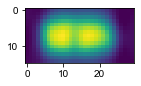

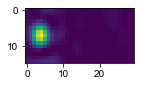

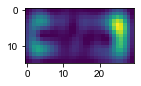

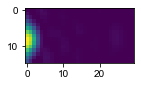

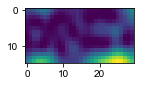

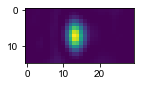

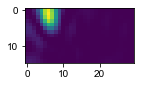

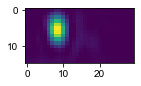

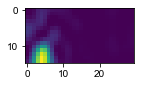

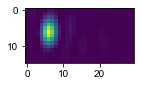

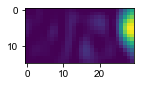

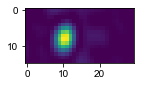

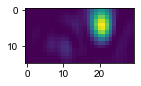

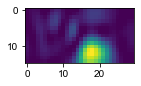

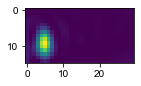

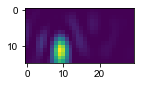

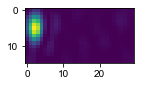

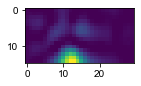

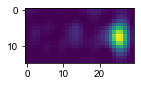

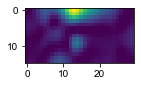

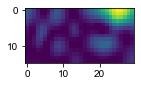

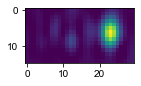

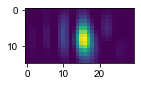

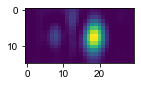

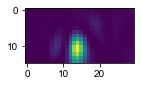

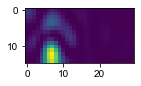

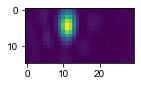

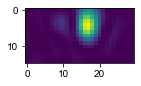

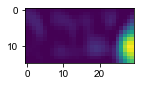

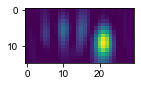

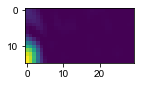

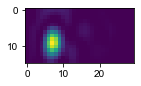

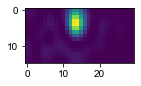

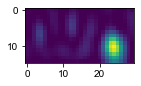

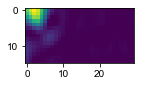

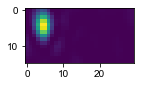

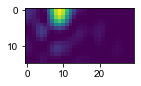

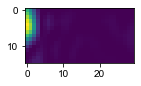

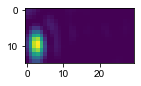

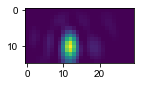

In [119]:
for i in range(n_components):
    fig=plt.figure(figsize=(2,1))
    plt.imshow(h[i].reshape(15,30))

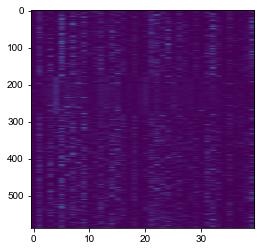

In [127]:
transformed = model.transform(gematria_data['MSR_PP1_A12_MSMEG_4323'][:,4:])
fig=plt.figure(figsize=(4,4))
plt.imshow(model.transform(gematria_data['MSR_PP1_A12_MSMEG_4323'][:,4:]),aspect='auto')

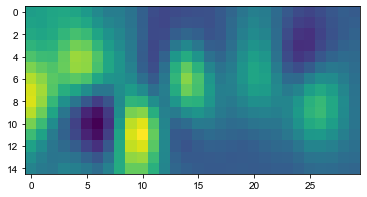

In [139]:
plt.imshow(transformed[200].dot(h).reshape(15,30))

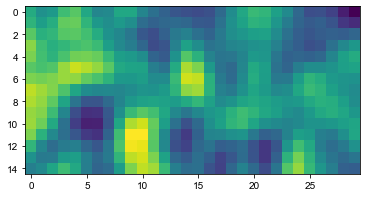

In [140]:
plt.imshow(gematria_data['MSR_PP1_A12_MSMEG_4323'][200,4:].reshape(15,30))

In [141]:
om.io.process_folder(source_folder='/Volumes/Extreme_SSD/Junhao_Imaging_data/MSR_raw_data/MSR_PP1_A12_MSMEG_4323//',
                     dest_folder='/Users/jz-rolling/Desktop/OMEGA/demo_data/demo_folder/',
                     split_branches=True,
                     save_input=True,
                     file_type='.nd2',n_cores=6)

In [5]:
om.io.measure_by_folder(dest_folder='/Users/jz-rolling/Desktop/OMEGA/demo_data/demo_folder/',
                        header='MSR_08_F01_MSMEG_4217')

In [6]:
d = om.io.pk.load(open('/Users/jz-rolling/Desktop/OMEGA/demo_data/demo_folder/MSR_08_F01_MSMEG_4217_miscellaneous_data.pk',
                       'rb'))

dict_keys(['is_outlier', 'lengths', 'cell_id', 'FITC', 'Phase_Ian'])

In [11]:
outlier = d['is_outlier']
lengths = d['lengths']
data = d['FITC']['padded_axial_data']

In [12]:
l_sorted = np.argsort(lengths)
data[l_sorted[outlier[l_sorted]==0]]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

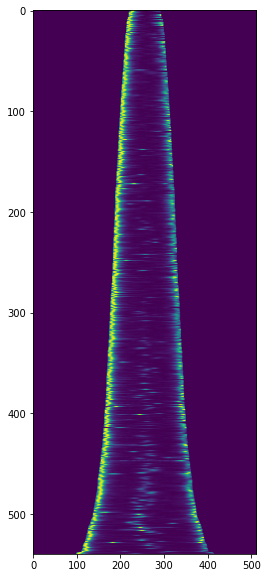

In [13]:
fig=plt.figure(figsize=(4,10))
plt.imshow(data[l_sorted[outlier[l_sorted]==0]],aspect='auto',vmax=1.)

In [14]:
cells = om.io.pickle_load_all_cells('/Users/jz-rolling/Desktop/OMEGA/demo_data/demo_folder/')

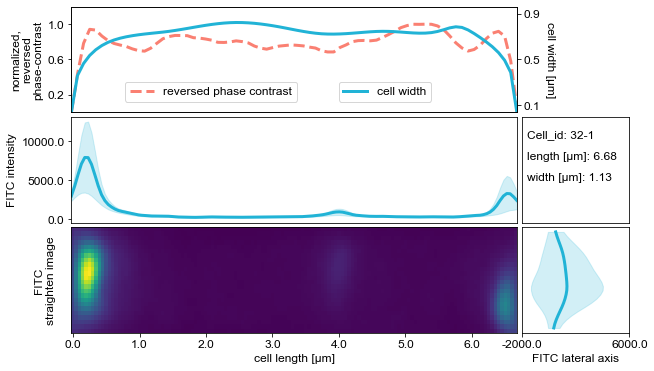

In [15]:
n=269
om.plot.cell_plot_full(cells[n])

In [16]:
plt.figure(figsize=(5,1))
cell = cells[268]
contour = om.helper.expand_contour(cell.optimized_contour, scale=1)
a,b,c,d = om.helper.straighten_by_orthogonal_lines(contour,
                                                  cell.midlines[0],
                                                  cell.lengths[0],
                                                   cell.width_lists[0])
e,f = om.helper.divide_contour_by_midline(cell.midlines[0],contour[:-1])

<Figure size 360x72 with 0 Axes>

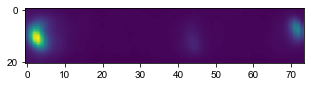

In [17]:
plt.figure(figsize=(5,1))
om.plot.plt.imshow(cells[n].measurements.signal_measurements['FITC']['straighten'],aspect='auto')

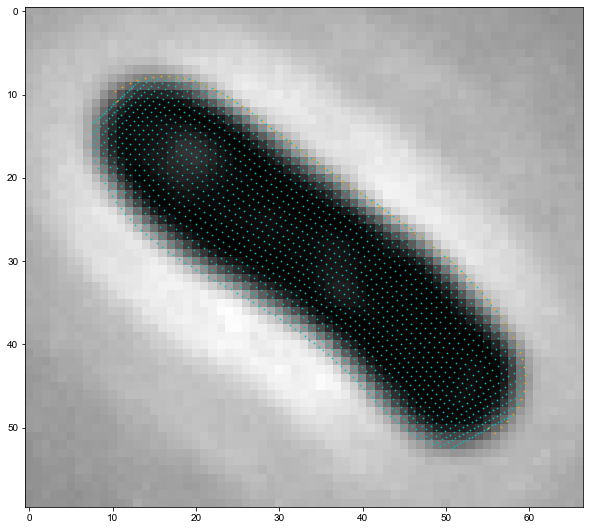

In [20]:
n=268
plt.figure(figsize=(10,10))
plt.imshow(cells[n].data['Phase_Ian'], cmap='gist_gray')
p = cells[n].profile_mesh
contour = cells[n].optimized_contour.copy()
dxy = om.helper.unit_perpendicular_vector(contour)
contour -= dxy
plt.scatter(p[1],p[0],s=0.5,c='c')
midline = cells[n].midline_interp
plt.scatter(e[:,1],e[:,0],s=0.6,c='orange')

In [19]:
l2 = om.io.orthogonal_intersection_point(cells[n].midline_interp, np.flip(f,axis=0),
                                       precomputed_orthogonal_vector=-om.helper.unit_perpendicular_vector(cells[n].midline_interp))

In [140]:
def orthogonal_intersection_point(midline,
                                  outerline,
                                  precomputed_orthogonal_vector=None):
    v1, v2 = outerline[:-1], outerline[1:]
    skel_x, skel_y = midline.T
    if precomputed_orthogonal_vector is None:
        intersect_x, intersect_y = intersect_matrix(midline, outerline)
    else:
        intersect_x, intersect_y = intersect_matrix(midline, outerline,
                                                    orthogonal_vectors=precomputed_orthogonal_vector)
    dx_v1 = intersect_x - v1.T[0][:, np.newaxis]
    dx_v2 = intersect_x - v2.T[0][:, np.newaxis]
    dy_v1 = intersect_y - v1.T[1][:, np.newaxis]
    dy_v2 = intersect_y - v2.T[1][:, np.newaxis]
    dx = dx_v1 * dx_v2
    dy = dy_v1 * dy_v2
    dist_x = skel_x[np.newaxis, :] - intersect_x
    dist_y = skel_y[np.newaxis, :] - intersect_y

    non_bounadry_points = np.where(np.logical_and(dy > 0, dx > 0))
    dist_matrix = np.sqrt(dist_x ** 2 + dist_y ** 2)
    dist_matrix[non_bounadry_points] = np.inf
    nearest_id_x = np.argsort(dist_matrix, axis=0)[:1]
    nearest_id_y = np.linspace(0, dist_matrix.shape[1] - 1, dist_matrix.shape[1]).astype(int)
    pos_list = np.array([intersect_x[nearest_id_x[0], nearest_id_y],
                         intersect_y[nearest_id_x[0], nearest_id_y]]).T
    return pos_list

In [64]:
xx=om.helper.intersect_matrix(cells[n].midline_interp, f)

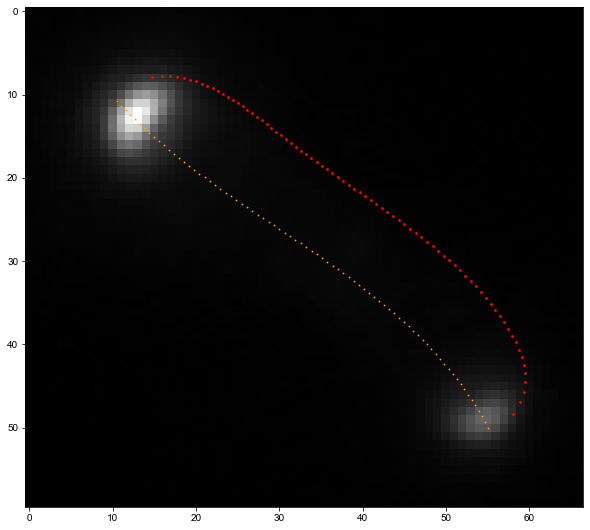

In [38]:
xx=om.helper.intersect_matrix(cells[n].midline_interp, e)
intersect_x, intersect_y = xx
v1, v2 = e[1:],e[:-1]
midl = cell.midline_interp
skel_x, skel_y = midl.T
dx_v1 = intersect_x - v1.T[0][:, np.newaxis]
dx_v2 = intersect_x - v2.T[0][:, np.newaxis]
dy_v1 = intersect_y - v1.T[1][:, np.newaxis]
dy_v2 = intersect_y - v2.T[1][:, np.newaxis]
dx = dx_v1 * dx_v2
dy = dy_v1 * dy_v2

dist_x = skel_x[np.newaxis, :] - intersect_x
dist_y = skel_y[np.newaxis, :] - intersect_y

non_bounadry_points = np.where(np.logical_and(dy >= 0, dx >= 0))
dist_matrix = np.sqrt(dist_x ** 2 + dist_y ** 2)
dist_matrix[non_bounadry_points] = np.inf
dist_matrix[dist_matrix<=0] = np.inf
nearest_id_x = np.argsort(dist_matrix, axis=0)[:1]
nearest_id_y = np.linspace(0, dist_matrix.shape[1] - 1, dist_matrix.shape[1]).astype(int)
pos_list = np.array([intersect_x[nearest_id_x[0], nearest_id_y],
                        intersect_y[nearest_id_x[0], nearest_id_y]]).T


n=268
plt.figure(figsize=(10,10))
plt.imshow(cells[n].data['FITC'], cmap='gist_gray')
p = cells[n].profile_mesh
contour = cells[n].optimized_contour.copy()
dxy = om.helper.unit_perpendicular_vector(contour)
contour -= dxy
#plt.scatter(p[1],p[0],s=0.5,c='c')
midline = cells[n].midline_interp
plt.scatter(l1[:,1],l1[:,0],s=3,c='r')
plt.scatter(midline[:,1],midline[:,0],s=0.6,c='orange')

In [122]:
dist_x = v1[:,0][:, np.newaxis] - intersect_x
dist_y = v2[:,1][:, np.newaxis] - intersect_y

In [22]:
l1=om.helper.orthogonal_intersection_point(cell.midline_interp, e)

In [40]:
dist_matrix[:,0]

array([           inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
      

In [130]:
intersect_x[:,0]

array([ 10.75705746,  23.53967299,  14.99277648,  13.7403997 ,
        13.43566785,  13.43644067,  13.5555979 ,  13.72919159,
        13.9315419 ,  14.15126915,  14.383529  ,  14.62704973,
        14.88294708,  15.15433336,  15.44576338,  15.75762169,
        16.08548318,  16.42519137,  16.77260523,  17.12358454,
        17.47398124,  17.81962998,  18.15633784,  18.47987331,
        18.78595445,  19.0702363 ,  19.32829762,  19.5556267 ,
        19.74760659,  19.8994994 ,  20.00642988,  20.06336817,
        20.06527776,  20.02078982,  19.94934909,  19.85131718,
        19.72524477,  19.56990486,  19.3843131 ,  19.16774358,
        18.91973941,  18.64011789,  18.32897008,  17.98665498,
        17.61378842,  17.21122735,  16.78004997,  16.32153251,
        15.83712356,  15.32841651,  14.79712127,  14.24503583,
        13.67366262,  13.09999224,  12.66255632,  12.42384888,
        12.38456177,  12.55157491,  12.93868084,  13.56748078,
        14.46899372,  15.68621226,  17.27800458,  19.32

array([[50.00876836, 55.07867106, 50.58892159, 55.84315016, 49.9304649 ,
        56.6454707 , 49.19577877, 57.38264901, 48.39199555, 58.03957572,
        47.52524613, 58.59937624, 46.60134954, 59.04241107, 45.63815774,
        59.343748  , 44.66667248, 59.49166257, 43.70032977, 59.5005971 ,
        42.74632696, 59.38844897, 41.8083475 , 59.17245895, 40.88815197,
        58.86832793, 39.9868416 , 58.49025194, 39.10557113, 58.05130485,
        38.24585328, 57.5638386 , 37.4094471 , 57.03965898, 36.59597433,
        56.48821627, 35.80425819, 55.91388043, 35.03356857, 55.31828193,
        34.28316849, 54.70297182, 33.55230919, 54.06948662, 32.84023339,
        53.41934853, 32.14617831, 52.75406606, 31.46937823, 52.07513508,
        30.80906674, 51.38404013, 30.1644786 , 50.68225578, 29.53485127,
        49.9712481 , 28.91942612, 49.25247611, 28.31744944, 48.52739325,
        27.72817323, 47.79744863, 27.15085582, 47.06408839, 26.58476246,
        46.32875676, 26.02916579, 45.5928972 , 25.4

In [144]:
# 1. Activate an OMEGA.Image object
data_folder = '/Users/jz-rolling/Desktop/OMEGA/demo_data/'
img = om.Image()

# 2. Load image file, specify the channel to be used for segmentation when a hyperstack image is provided.
# For instance, if the .nd2 file has two channels, phase contrast and FITC, which are stacked accordingly,
# then the index for phase contrast channel will be 0, and the index for FITC channel will be 1 (or -1 with Python)

# 2-1. Load .nd2 image data
#img.read_nd2_file(data_folder + 'mild_clumping.nd2', mask_channel_id=-1)

# 2-2. Or .tiff file:
img.read_nd2_file('/Volumes/Extreme_SSD/Junhao_Imaging_data/MSR_raw_data/MSR_PP1_A12_MSMEG_4323/MSR_PP1_A12_MSMEG_4323_003.nd2', mask_channel_id=-1)

# 3. Import configurations
config_file = '/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/configuration_msm.ini'
img.config = om.config.Preset_configurations_default(config_file).config

In [156]:
shift

array([-39.3,  -2.6])

In [155]:
reference_image = img.data[img.mask_channel_name]
#reference_image = 100 + reference_image.max() - reference_image
for channel, data in img.data.items():
    if channel != img.mask_channel_name:
        shift, error, _diff = om.image.registration.phase_cross_correlation(reference_image, dd,
                                                                            upsample_factor=10)

In [ ]:
                    if max(shift) <= max_drift:
                        offset_image = helper.shift_image(data, shift)
                        self.data[channel] = offset_image[h1:h2, w1:w2]
                    else:
                        self.data[channel] = self.data[channel][h1:h2, w1:w2]
                else:
                    self.data[channel] = self.data[channel][h1:h2, w1:w2]